<a href="https://colab.research.google.com/github/DevHyunseo/PoscoAcademy_Bigdata/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83_%EC%A2%85%ED%95%A9%EC%8B%A4%EC%8A%B5(%EB%8C%80%ED%98%95%EB%A7%88%ED%8A%B8)_%EC%8B%9C%EA%B0%84%EB%8C%80%EB%B3%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
sns.set_palette('Pastel1')
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes",unicode_minus = False)
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 최적 모델, 파라미터 탐색
#
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 고객데이터

In [ ]:
df = pd.read_csv("/home/piai/다운로드/대형마트/member_data.csv")

In [ ]:
df[['구', '동']] = df['주소'].str.split('-', 1, expand=True)

# 고객데이터 박스플랏

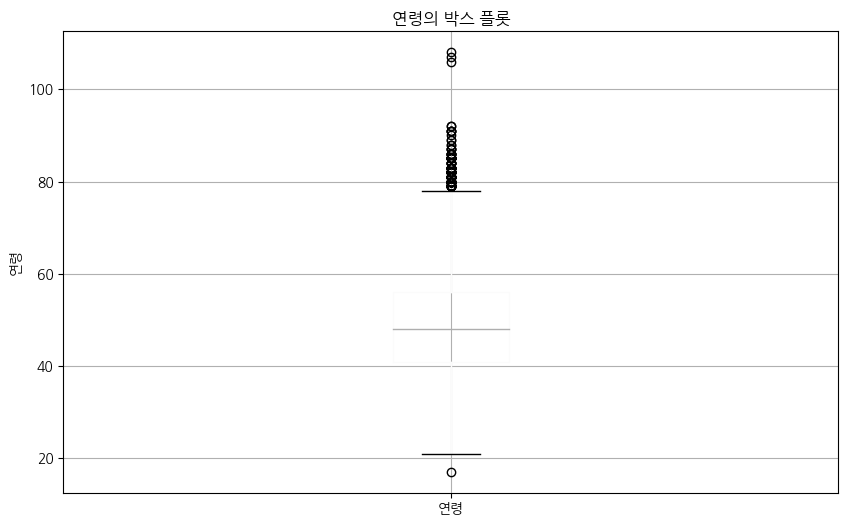

In [ ]:
plt.figure(figsize=(10, 6))
boxplot = df[['연령']].boxplot()
plt.title('연령의 박스 플롯')
plt.ylabel('연령')

# y축 레이블을 정수로 표시
y_labels = boxplot.get_yticks().astype(int)
boxplot.set_yticklabels(y_labels)

plt.show()

In [ ]:
# 연령을 범주형 데이터로 변환 (10년 단위로 나이대 분류)
bins = [0, 29, 39, 49, 59, 69, float('inf')]
labels = ['20대 이하', '30대', '40대', '50대', '60대', '70대 이상']
df['연령대'] = pd.cut(df['연령'], bins=bins, labels=labels, right=False)

In [ ]:
df.drop(['주소', '연령'], axis=1, inplace=True) #이미 쓴놈들 제외

In [ ]:
df['조합원상태'] = df['조합원상태'].apply(lambda x: x if x == '정상회원' else '탈퇴회원')

In [ ]:
df['조합원상태'].value_counts()

정상회원    11413
탈퇴회원      142
Name: 조합원상태, dtype: int64

In [ ]:
df[df['연령' > '100']]

KeyError: True

In [ ]:
missing_gender = df[df['성별'].isna()]
# 결측값이 있는 행들을 출력
print("성별 결측값이 있는 행들:")
missing_gender

성별 결측값이 있는 행들:


,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대
3666,1527053696,정상회원,NaN,미신청,.,normal,기타,기타,40대
7098,545864448,정상회원,NaN,미신청,.,normal,기타,기타,NaN


In [ ]:
missing_age = df[df['연령대'].isna()]
# 결측값이 있는 행들을 출력
print("나이 결측값이 있는 행들:")
missing_age

나이 결측값이 있는 행들:


,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,Gold_member,구,동,연령대
5983,383599936,정상회원,여,미신청,.,normal,기타,기타,NaN
7098,545864448,정상회원,NaN,미신청,.,normal,기타,기타,NaN


In [ ]:
# 성별과 연령대의 결측값 제거
df = df.drop(index=3666)
df = df.drop(index=7098) #7098 성별, 나이 둘다 없는 친구 그래서 3개
df = df.drop(index=5983)

In [ ]:
df.isnull().sum()

회원번호           0
조합원상태          0
성별             0
배송서비스신청여부      0
모바일알람여부        0
Gold_member    0
구              0
동              0
연령대            0
dtype: int64

In [ ]:
del df['Gold_member'] #RFM분석을 통해 새로운 VIP만들꺼라서(나무 뭐시기)

In [ ]:
df["모바일알람여부"].value_counts() #수신이 너무 적다 해결방안 필요

.     10650
수신      902
Name: 모바일알람여부, dtype: int64

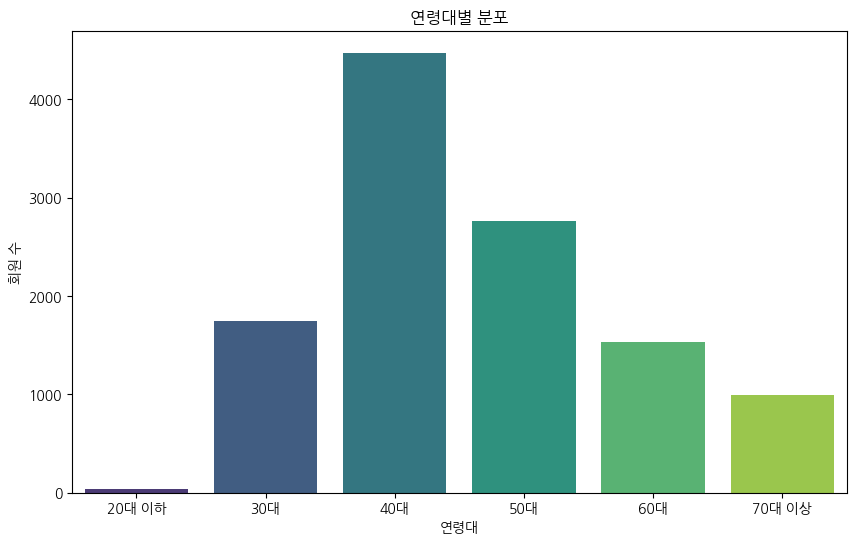

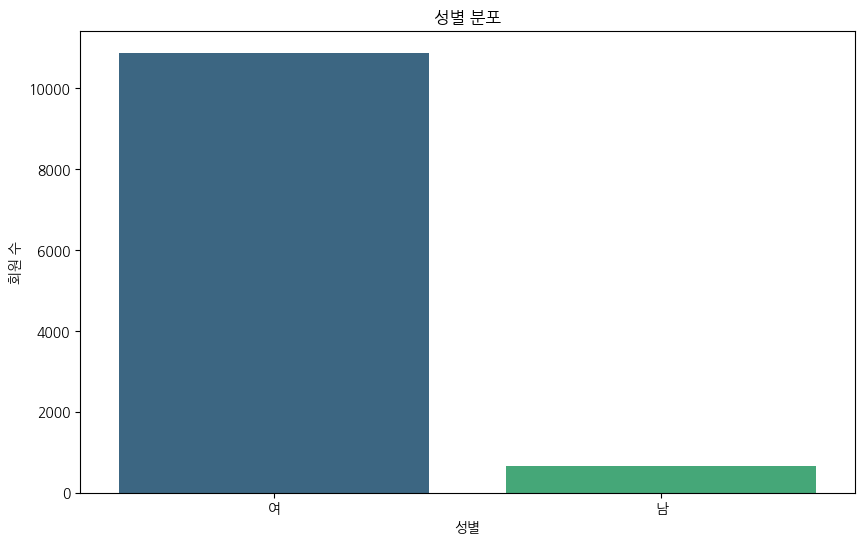

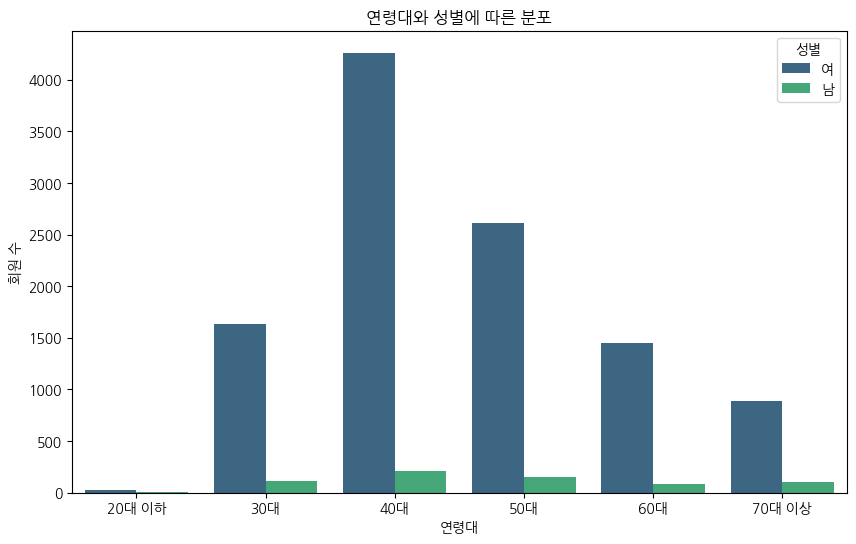

In [ ]:
# 1. 연령대별 분포
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='연령대', palette='viridis')
plt.title('연령대별 분포')
plt.xlabel('연령대')
plt.ylabel('회원 수')
plt.show()

# 2. 성별 분포
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='성별', palette='viridis')
plt.title('성별 분포')
plt.xlabel('성별')
plt.ylabel('회원 수')
plt.show()

# 3. 연령대와 성별에 따른 분포
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='연령대', hue='성별', palette='viridis')
plt.title('연령대와 성별에 따른 분포')
plt.xlabel('연령대')
plt.ylabel('회원 수')
plt.legend(title='성별')
plt.show()


Text(0, 0.5, '')

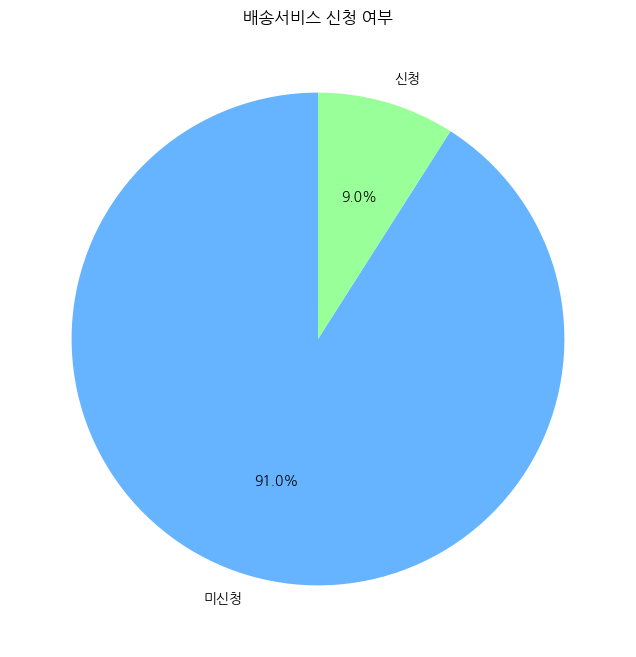

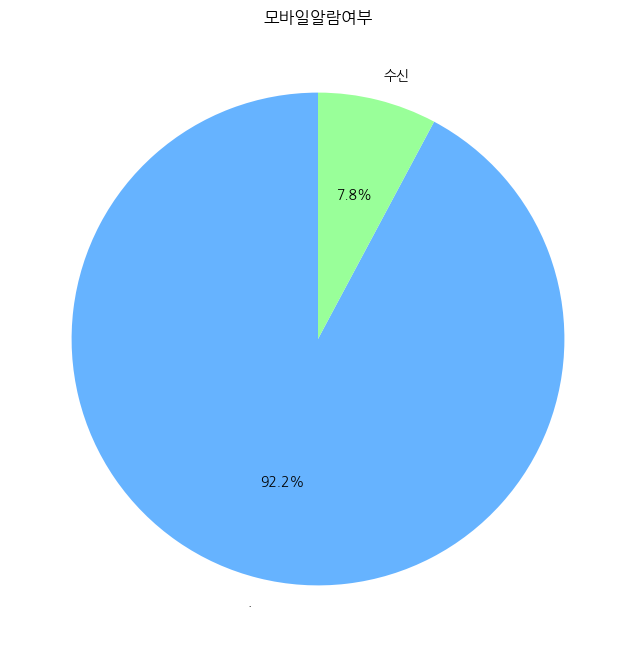

In [ ]:
plt.figure(figsize=(8, 8))
df['배송서비스신청여부'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title('배송서비스 신청 여부')
plt.ylabel('')

plt.figure(figsize=(8, 8))
df['모바일알람여부'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title('모바일알람여부')
plt.ylabel('')


In [ ]:
df

,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,구,동,연령대
0,1000012800,정상회원,여,미신청,.,수지구,풍덕천동,50대
1,1000103744,정상회원,여,미신청,.,처인구,고림동,30대
2,1000122304,정상회원,여,미신청,.,광주,기타,30대
3,1000163136,정상회원,여,미신청,.,수지구,동천동,70대 이상
4,1000281920,정상회원,여,신청,.,수지구,풍덕천동,40대
...,...,...,...,...,...,...,...,...
11550,999682432,탈퇴회원,여,미신청,.,수지구,동천동,40대
11551,999721408,정상회원,여,미신청,.,수지구,동천동,40대
11552,999738112,정상회원,여,미신청,.,수지구,성복동,60대
11553,999754816,정상회원,여,신청,.,수지구,상현동,40대


- 배송서비스 신청 비율이 너무나 낮게나옴, 어플리케이션을 이용하는 비율이 낮기 때문? 이유 중 하나

- VIP의 숫자가 총 회원에 비해 너무 적어서 RFM방식을 통해 재정립 필요

- 모바일 알람 수신 비율이 너무나 낮게나옴, 어플리케이션을 이용하는 비율이 낮기 때문? 이유 중 하나

# 판매데이터

In [ ]:
df1 = pd.read_csv("/home/piai/다운로드/대형마트/product_data_001.csv", encoding = 'euc-kr')
df2 = pd.read_csv("/home/piai/다운로드/대형마트/product_data_002.csv", encoding = 'euc-kr')
df3 = pd.read_csv("/home/piai/다운로드/대형마트/product_data_003.csv", encoding = 'euc-kr')
df4 = pd.read_csv("/home/piai/다운로드/대형마트/product_data_004.csv", encoding = 'euc-kr')
dfm = pd.concat([df4, df3, df1, df2], ignore_index=True)
dfm
# dfm.to_csv("/home/piai/다운로드/대형마트/product_m.csv", encoding = 'euc-kr')

,Unnamed: 0.1,Unnamed: 0,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자
0,0,0,2023-01-06,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,10:32,NaN
1,1,1,2023-01-06,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,10:41,NaN
2,2,2,2023-01-06,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:00,NaN
3,3,3,2023-01-06,786634048,탈퇴,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,11:28,NaN
4,4,4,2023-01-06,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:59,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294640,55103,55103,2023-11-04,560448896,정상회원,주곡,멥쌀,멥쌀,백미/유(2kg),1.0,15315,매장D,13:16,NaN
294641,55104,55104,2023-11-04,68976384,정상회원,채소,잎/줄기채소,시금치,시금치(300g),2.0,6892,매장D,11:08,NaN
294642,55105,55105,2023-11-04,1519813440,정상회원,반찬,밑반찬,김가공,구운자른김(15g*3봉),1.0,7466,매장D,14:27,NaN
294643,55106,55106,2023-11-04,654809792,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3733,매장D,16:02,NaN


In [ ]:
dfm[['년','월','일']] = dfm['공급일자'].str.split('-', 2, expand=True)

In [ ]:
dfm.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
#쓸데 없는놈들 드랍

In [ ]:
dfm.isnull().sum()
# 결측치가 없다

공급일자          0
회원번호          0
조합원상태         0
물품대분류         0
물품중분류         0
물품소분류         0
물품명           0
구매수량          0
구매금액          0
구매매장          0
구매시각          0
반품일자     289685
년             0
월             0
일             0
dtype: int64

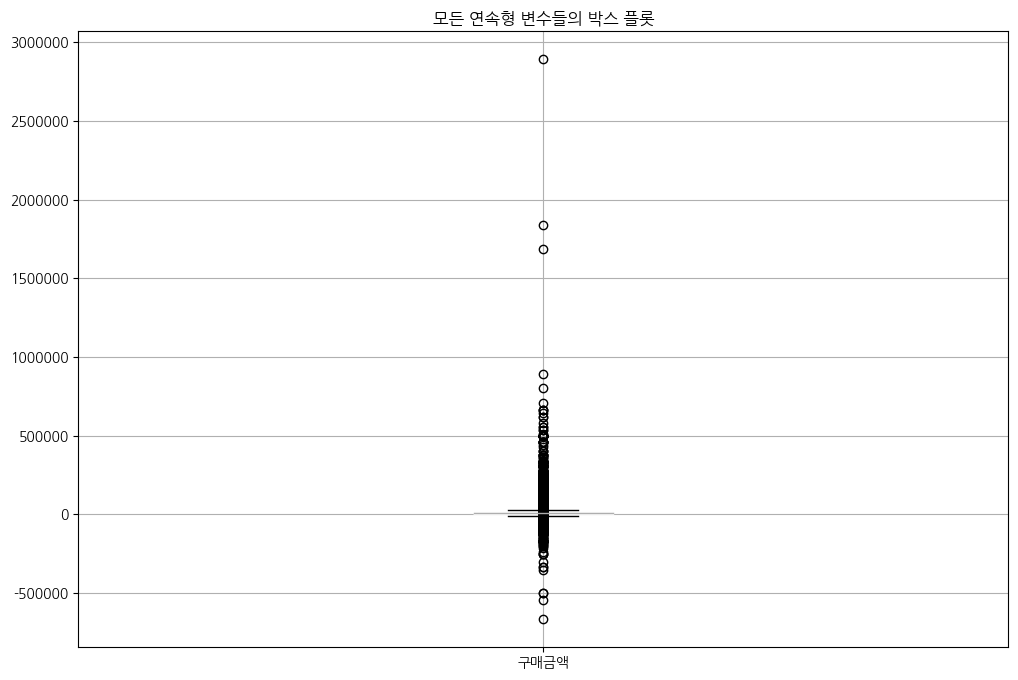

In [ ]:
plt.figure(figsize=(12, 8))
boxplot = dfm[['구매금액']].boxplot()
plt.title('모든 연속형 변수들의 박스 플롯')

# y축 레이블을 정수로 표시
for column in dfm.columns:
    y_labels = boxplot.get_yticks().astype(int)
    boxplot.set_yticklabels(y_labels)

plt.show()

In [ ]:
dfm[dfm['구매금액']>1500000]

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
35788,2023-07-27,153723200,정상회원,채소,버섯,상황버섯,린테우스상황버섯(200g/유),10.0,2890766,매장A,19:11,NaN,2023,07,27
193243,2023-07-11,357357952,정상회원,건강,홍삼/녹용,홍삼,홍삼액(6년근/60봉),8.0,1837838,매장C,16:23,NaN,2023,07,11
249098,2023-02-27,742461248,정상회원,양념/가루,장,메주,메주(1말:약6-7kg:솔뫼),9.0,1688514,매장D,11:30,NaN,2023,02,27


In [ ]:
dfm[dfm['물품명']=='린테우스상황버섯(200g/유)']
dfm = dfm.drop(index=35788)

#이상치 삭제 검색결과 200g이 300만원에 육박하는 경우는 보지 못했음

In [ ]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294644 entries, 0 to 294644
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   공급일자    294644 non-null  object 
 1   회원번호    294644 non-null  int64  
 2   조합원상태   294644 non-null  object 
 3   물품대분류   294644 non-null  object 
 4   물품중분류   294644 non-null  object 
 5   물품소분류   294644 non-null  object 
 6   물품명     294644 non-null  object 
 7   구매수량    294644 non-null  float64
 8   구매금액    294644 non-null  int64  
 9   구매매장    294644 non-null  object 
 10  구매시각    294644 non-null  object 
 11  반품일자    4960 non-null    object 
 12  년       294644 non-null  object 
 13  월       294644 non-null  object 
 14  일       294644 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 36.0+ MB


In [ ]:
dfm["조합원상태"].value_counts() #제품 규격 기준국

정상회원     291370
탈퇴         3216
탈퇴처리중        53
탈퇴신청          5
Name: 조합원상태, dtype: int64

In [ ]:
dfm['조합원상태'] = dfm['조합원상태'].apply(lambda x: x if x == '정상회원' else '탈퇴회원')

In [ ]:
dfm["조합원상태"].value_counts() #제품 규격 기준국

정상회원    291370
탈퇴회원      3274
Name: 조합원상태, dtype: int64

In [ ]:
dfm

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
0,2023-01-06,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,10:32,NaN,2023,01,06
1,2023-01-06,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,10:41,NaN,2023,01,06
2,2023-01-06,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:00,NaN,2023,01,06
3,2023-01-06,786634048,탈퇴회원,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,11:28,NaN,2023,01,06
4,2023-01-06,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:59,NaN,2023,01,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294640,2023-11-04,560448896,정상회원,주곡,멥쌀,멥쌀,백미/유(2kg),1.0,15315,매장D,13:16,NaN,2023,11,04
294641,2023-11-04,68976384,정상회원,채소,잎/줄기채소,시금치,시금치(300g),2.0,6892,매장D,11:08,NaN,2023,11,04
294642,2023-11-04,1519813440,정상회원,반찬,밑반찬,김가공,구운자른김(15g*3봉),1.0,7466,매장D,14:27,NaN,2023,11,04
294643,2023-11-04,654809792,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3733,매장D,16:02,NaN,2023,11,04


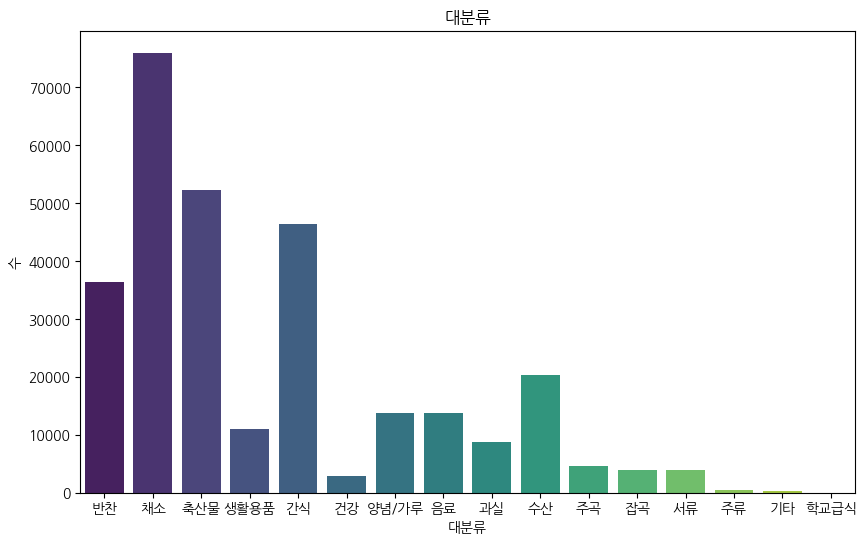

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dfm, x='물품대분류', palette='viridis')
plt.title('대분류')
plt.xlabel('대분류')
plt.ylabel('수')
plt.show()

In [ ]:
dfm[dfm['물품대분류']=='학교급식'] #삭제
dfm = dfm.drop(index=292651)


In [ ]:
dfm[dfm["구매금액"] == 0] #삭제 455개 but 구매수량 0인거랑 중복될수 있음

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
1157,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,17:24,2023-01-13,2023,01,12
1183,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,17:50,NaN,2023,01,12
1284,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,18:09,2023-01-13,2023,01,12
3766,2023-01-26,38808960,정상회원,채소,뿌리채소,울금,울금(500g),0.0,0,매장A,19:44,NaN,2023,01,26
3904,2023-01-27,64306688,정상회원,서류,고구마,고구마,황금고구마(1kg),0.0,0,매장A,13:51,NaN,2023,01,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293288,2023-10-27,330410688,정상회원,생활용품,화장품,유아/썬크림,자연그대로 아토크림(증정/15g),1.0,0,매장D,12:33,NaN,2023,10,27
293647,2023-10-29,993938112,정상회원,생활용품,화장품,유아/썬크림,자연그대로 아토크림(증정/15g),1.0,0,매장D,19:21,NaN,2023,10,29
293775,2023-10-30,993938112,정상회원,축산물,유제품,우유/산양유,저지방우유(범산/900ml),0.0,0,매장D,10:33,NaN,2023,10,30
293826,2023-10-30,605683328,정상회원,생활용품,화장품,유아/썬크림,자연그대로 아토크림(증정/15g),1.0,0,매장D,11:13,NaN,2023,10,30


In [ ]:
# dfm[(dfm['구매금액'] == 0) & (dfm['구매수량'] == 1)]
# item_names = dfm[(dfm['구매금액'] == 0) & (dfm['구매수량'] == 1)]['물품명']
# item_names
# # 일단 이것들은 전부 증정용 어떻게 처리하지?

In [ ]:
dfm[dfm["구매수량"] == 0] #삭제 65개 마찬가지로 중복될 수 있음
# 증정품은 판매데이터 아니라서 밀자, 2안 프로모션기간인가?
#일단 킵

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
1157,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,17:24,2023-01-13,2023,01,12
1183,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,17:50,NaN,2023,01,12
1284,2023-01-12,555987072,정상회원,과실,과일,사과,사과/(2kg)/중,0.0,0,매장A,18:09,2023-01-13,2023,01,12
3766,2023-01-26,38808960,정상회원,채소,뿌리채소,울금,울금(500g),0.0,0,매장A,19:44,NaN,2023,01,26
3904,2023-01-27,64306688,정상회원,서류,고구마,고구마,황금고구마(1kg),0.0,0,매장A,13:51,NaN,2023,01,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282277,2023-08-27,112698176,정상회원,채소,과일채소,완숙토마토,완숙토마토(2kg),0.0,0,매장D,10:59,NaN,2023,08,27
284205,2023-09-05,1047253568,정상회원,축산물,유제품,우유/산양유,유기농저지방우유(종이팩/900ml),0.0,0,매장D,11:57,NaN,2023,09,05
284470,2023-09-07,52558208,정상회원,채소,과일채소,완숙토마토,완숙토마토(2kg),0.0,0,매장D,10:11,NaN,2023,09,07
284755,2023-09-09,52558208,정상회원,채소,과일채소,완숙토마토,완숙토마토(2kg),0.0,0,매장D,10:37,NaN,2023,09,09


In [ ]:
dfm[dfm["물품명"] == "중성세제 샘플(증정/100㎖)"]["공급일자"].value_counts()
#프로모션 기간 체크 #프로모션때문에 못지우고 있는거

2023-03-28    21
2023-03-27    17
2023-03-25    15
2023-03-24    13
2023-03-26    11
2023-03-23     9
2023-03-29     7
Name: 공급일자, dtype: int64

In [ ]:
dfm[dfm["물품명"]== "조합원의식조사설문"]
dfm = dfm[dfm["물품명"]!= "조합원의식조사설문"]
# 이게 삭제코드

In [ ]:
dfm[(dfm["물품명"] == "통삼겹-성남용인") & (dfm["구매금액"] == 0)]
dfm = dfm.drop(index=134334)

#이거 삭제 무조건 금액예측이 안됨

In [ ]:
dfm[(dfm["구매수량"] <0)]
# 이건 전부 환불로 생각 그냥 두자

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
88,2023-01-06,74562944,정상회원,간식,떡,즉석떡,말랑말랑백미가래떡(400g),-1.0,-6318,매장A,19:58,2023-01-07,2023,01,06
108,2023-01-06,796003136,정상회원,축산물,육가공,햄/소시지/훈제,김밥용햄(285g),-1.0,-8615,매장A,15:07,NaN,2023,01,06
145,2023-01-06,554236864,정상회원,간식,빵,"찐빵,호떡,전통",팥찐빵(5개:400g)/매장,-1.0,-7275,매장A,15:40,2023-01-08,2023,01,06
744,2023-01-09,1474985472,정상회원,간식,떡,즉석떡,모듬배기찰떡(160g),-1.0,-5743,매장A,15:20,2023-01-12,2023,01,09
827,2023-01-10,1390554176,정상회원,축산물,유제품,우유/산양유,목초우유(900ml),-1.0,-11295,매장A,12:48,2023-01-11,2023,01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294283,2023-11-02,1618521088,정상회원,축산물,육가공,햄/소시지/훈제,슬라이스햄(200g)-매장,-1.0,-6509,매장D,12:56,2023-11-05,2023,11,02
294304,2023-11-02,1163403904,정상회원,주곡,멥쌀,멥쌀,칠분도미/유(2kg),-1.0,-15124,매장D,18:58,2023-11-03,2023,11,02
294466,2023-11-04,654809792,정상회원,양념/가루,가루,프리믹스,핫케이크가루(600g),-1.0,-8041,매장D,16:02,2023-11-07,2023,11,04
294558,2023-11-04,654809792,정상회원,반찬,두부/유부,두부,두부(1모:420g),-1.0,-3733,매장D,16:02,2023-11-05,2023,11,04


In [ ]:
#개수 소수점인것은 금액 비례하는 것 확인 지우는것 불필요
dfm[dfm["물품명"] == "배/(대:5kg)"]


,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
257,2023-01-07,438814080,정상회원,과실,과일,배,배/(대:5kg),0.25,10338,매장A,12:45,NaN,2023,01,07
62669,2023-02-18,377644032,정상회원,과실,과일,배,배/(대:5kg),1.00,41351,매장B,16:10,NaN,2023,02,18
63888,2023-02-27,392584832,정상회원,과실,과일,배,배/(대:5kg),0.50,20676,매장B,15:19,NaN,2023,02,27
118765,2023-01-11,153747328,정상회원,과실,과일,배,배/(대:5kg),1.00,41351,매장C,16:25,NaN,2023,01,11
122610,2023-01-20,691612416,정상회원,과실,과일,배,배/(대:5kg),0.50,20676,매장C,11:47,NaN,2023,01,20
122781,2023-01-20,747264576,정상회원,과실,과일,배,배/(대:5kg),0.50,20676,매장C,11:11,NaN,2023,01,20
122933,2023-01-20,470496000,정상회원,과실,과일,배,배/(대:5kg),0.50,20676,매장C,15:58,NaN,2023,01,20
130321,2023-02-07,1205299392,정상회원,과실,과일,배,배/(대:5kg),-1.00,-41351,매장C,14:52,2023-02-08,2023,02,07
134193,2023-02-16,744588224,정상회원,과실,과일,배,배/(대:5kg),4.00,165405,매장C,14:07,NaN,2023,02,16
135379,2023-02-18,19627200,정상회원,과실,과일,배,배/(대:5kg),1.00,41351,매장C,15:09,NaN,2023,02,18


In [ ]:
dfm[(dfm["반품일자"].notna()) & (dfm['구매수량'] > 0)]
dfm = dfm.drop(index = 849)
dfm = dfm.drop(index = 105556)
dfm = dfm.drop(index = 161974)
dfm = dfm.drop(index = 261634)

#반품일자가 떠있지만 반품이 아닌 구매데이터임
# 4개 뒤지게 이상함 지울듯?

In [ ]:
dfm[dfm["회원번호"] == 151032000]
#매장ABCD 전부 구매시각 기준으로 정렬한 후에 다시 확인 #just확인

,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일
823,2023-01-10,151032000,정상회원,과실,과일,참다래,참다래(골드:2kg),1.0,28333,매장A,11:28,NaN,2023,01,10
825,2023-01-10,151032000,정상회원,간식,빵,페스츄리류,크루아상(150g)/매장,1.0,6509,매장A,11:54,NaN,2023,01,10
876,2023-01-10,151032000,정상회원,채소,잎/줄기채소,시금치,시금치(300g),1.0,4403,매장A,11:28,NaN,2023,01,10
879,2023-01-10,151032000,정상회원,채소,과일채소,딸기,딸기(1kg),-1.0,-31588,매장A,11:53,2023-01-11,2023,01,10
907,2023-01-10,151032000,정상회원,생활용품,화장품,세안제/팩,수피아 해맑은 클렌징폼(120㎖),-1.0,-16655,매장A,11:53,2023-01-11,2023,01,10
934,2023-01-10,151032000,정상회원,주곡,멥쌀,멥쌀,오분도미/유(8kg)-매장용,-1.0,-57432,매장A,11:52,2023-01-13,2023,01,10
960,2023-01-10,151032000,정상회원,생활용품,화장품,세안제/팩,수피아 해맑은 클렌징폼(120㎖),1.0,16655,매장A,11:28,NaN,2023,01,10
962,2023-01-10,151032000,정상회원,주곡,멥쌀,멥쌀,오분도미/유(8kg)-매장용,-1.0,-57432,매장A,11:53,2023-01-11,2023,01,10
983,2023-01-10,151032000,정상회원,축산물,알,유정란,동물복지유정란/중란(10알/국내산),2.0,11104,매장A,11:28,NaN,2023,01,10
984,2023-01-10,151032000,정상회원,과실,과일,참다래,참다래(골드:2kg),-1.0,-28333,매장A,11:52,2023-01-11,2023,01,10


In [ ]:
dfm[['년','월','일']] = dfm['공급일자'].str.split('-', 2, expand=True)

In [ ]:
# '년', '월', '일'을 결합하여 '방문일' 컬럼 생성
dfm['최근방문일'] = pd.to_datetime(dfm['년'] + '-' + dfm['월'] + '-' + dfm['일'], format='%Y-%m-%d')

# 회원번호별로 가장 최근 방문일 찾기
recent_visits = dfm.groupby('회원번호')['최근방문일'].max().reset_index()

# 결과 출력
print(recent_visits)
# del dfm['방문일']

             회원번호      최근방문일
0        18613824 2023-07-08
1        18764160 2023-08-27
2        18792000 2023-04-09
3        18942336 2023-10-24
4        18949760 2023-10-04
...           ...        ...
11550  1644772352 2023-11-03
11551  1644957952 2023-11-03
11552  1670400000 2023-11-04
11553  1670606016 2023-10-16
11554  1670620864 2023-06-10

[11555 rows x 2 columns]


In [ ]:
# '년', '월', '일'을 결합하여 '방문일' 컬럼 생성
dfm['최근방문일'] = pd.to_datetime(dfm['년'] + '-' + dfm['월'] + '-' + dfm['일'], format='%Y-%m-%d')

# 기준 날짜 설정
reference_date = pd.to_datetime('2023-11-04')

# 기준 날짜와 방문일의 차이 계산
dfm['일차'] = (reference_date - dfm['최근방문일']).dt.days

# 각 회원번호별로 가장 최근 방문일 찾기
recent_visits = dfm.loc[dfm.groupby('회원번호')['최근방문일'].idxmax()].reset_index(drop=True)

# 그룹화 조건에 따라 그룹 할당
def assign_group(days):
    if days <= 14:
        return 4
    elif days <= 30:
        return 3
    elif days <= 90:
        return 2
    else:
        return 1


recent_visits['최근방문일그룹화'] = recent_visits['일차'].apply(assign_group)

# 최근 방문일 기준으로 그룹 정보를 원래 데이터프레임에 추가
dfm = pd.merge(dfm, recent_visits[['회원번호', '최근방문일그룹화']], on='회원번호', how='left')

# 결과 출력
dfm


,공급일자,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,구매금액,구매매장,구매시각,반품일자,년,월,일,최근방문일,일차,최근방문일그룹화
0,2023-01-06,220954944,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3829,매장A,10:32,NaN,2023,01,06,2023-01-06,302,4
1,2023-01-06,89023040,정상회원,채소,열매채소,단호박/손질,단호박(깍뚝썰기/300g),1.0,4977,매장A,10:41,NaN,2023,01,06,2023-01-06,302,4
2,2023-01-06,354941440,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:00,NaN,2023,01,06,2023-01-06,302,2
3,2023-01-06,786634048,탈퇴회원,반찬,어묵/묵,묵,도토리묵(420g:1모),1.0,7083,매장A,11:28,NaN,2023,01,06,2023-01-06,302,1
4,2023-01-06,438543104,정상회원,축산물,알,유정란,유정란/매장용(10알/국내산),1.0,7083,매장A,11:59,NaN,2023,01,06,2023-01-06,302,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294546,2023-11-04,560448896,정상회원,주곡,멥쌀,멥쌀,백미/유(2kg),1.0,15315,매장D,13:16,NaN,2023,11,04,2023-11-04,0,4
294547,2023-11-04,68976384,정상회원,채소,잎/줄기채소,시금치,시금치(300g),2.0,6892,매장D,11:08,NaN,2023,11,04,2023-11-04,0,4
294548,2023-11-04,1519813440,정상회원,반찬,밑반찬,김가공,구운자른김(15g*3봉),1.0,7466,매장D,14:27,NaN,2023,11,04,2023-11-04,0,4
294549,2023-11-04,654809792,정상회원,반찬,두부/유부,두부,두부(1모:420g),1.0,3733,매장D,16:02,NaN,2023,11,04,2023-11-04,0,4


In [ ]:
# 원래 데이터프레임 df에 그룹 정보를 추가
df = pd.merge(df, recent_visits[['회원번호', '최근방문일그룹화']], on='회원번호', how='left')

# # 불필요한 컬럼 제거
# df = df.drop(columns=['방문일', '일차'])

# 결과 출력
df

,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,구,동,연령대,최근방문일그룹화
0,1000012800,정상회원,여,미신청,.,수지구,풍덕천동,50대,1
1,1000103744,정상회원,여,미신청,.,처인구,고림동,30대,3
2,1000122304,정상회원,여,미신청,.,광주,기타,30대,4
3,1000163136,정상회원,여,미신청,.,수지구,동천동,70대 이상,4
4,1000281920,정상회원,여,신청,.,수지구,풍덕천동,40대,3
...,...,...,...,...,...,...,...,...,...
11547,999682432,탈퇴회원,여,미신청,.,수지구,동천동,40대,1
11548,999721408,정상회원,여,미신청,.,수지구,동천동,40대,2
11549,999738112,정상회원,여,미신청,.,수지구,성복동,60대,4
11550,999754816,정상회원,여,신청,.,수지구,상현동,40대,4


In [ ]:
# del df['그룹']
df['최근방문일그룹화'].value_counts()

4    3841
1    3624
2    2505
3    1582
Name: 최근방문일그룹화, dtype: int64

In [ ]:
total_purchase_by_member = dfm.groupby('회원번호')['구매금액'].sum().reset_index()
total_purchase_by_member.columns = ['회원번호', '총구매금액']

# 원래 데이터프레임 dfm에 총구매금액 정보 추가
dfm = pd.merge(dfm, total_purchase_by_member, on='회원번호', how='left')

# 결과 출력
print(dfm)


              공급일자        회원번호 조합원상태 물품대분류   물품중분류   물품소분류               물품명  \
0       2023-01-06   220954944  정상회원    반찬   두부/유부      두부       두부(1모:420g)   
1       2023-01-06    89023040  정상회원    채소    열매채소  단호박/손질    단호박(깍뚝썰기/300g)   
2       2023-01-06   354941440  정상회원   축산물       알     유정란  유정란/매장용(10알/국내산)   
3       2023-01-06   786634048  탈퇴회원    반찬    어묵/묵       묵     도토리묵(420g:1모)   
4       2023-01-06   438543104  정상회원   축산물       알     유정란  유정란/매장용(10알/국내산)   
...            ...         ...   ...   ...     ...     ...               ...   
294546  2023-11-04   560448896  정상회원    주곡      멥쌀      멥쌀         백미/유(2kg)   
294547  2023-11-04    68976384  정상회원    채소  잎/줄기채소     시금치         시금치(300g)   
294548  2023-11-04  1519813440  정상회원    반찬     밑반찬     김가공     구운자른김(15g*3봉)   
294549  2023-11-04   654809792  정상회원    반찬   두부/유부      두부       두부(1모:420g)   
294550  2023-11-04   349564608  정상회원    채소    열매채소     애호박           애호박(1개)   

        구매수량   구매금액 구매매장   구매시각 반품일자   

In [ ]:
# dfm[dfm['총구매금액']<0] 이거 확인해야함

In [ ]:
total_purchase_by_member = dfm.groupby('회원번호')['구매금액'].sum().reset_index()
total_purchase_by_member.columns = ['회원번호', '총구매금액']

# df 데이터프레임에 총구매금액 정보 추가
df = pd.merge(df, total_purchase_by_member, on='회원번호', how='left')

# 결과 출력
print(df)

             회원번호 조합원상태 성별 배송서비스신청여부 모바일알람여부    구     동     연령대  최근방문일그룹화  \
0      1000012800  정상회원  여       미신청       .  수지구  풍덕천동     50대         1   
1      1000103744  정상회원  여       미신청       .  처인구   고림동     30대         3   
2      1000122304  정상회원  여       미신청       .   광주    기타     30대         4   
3      1000163136  정상회원  여       미신청       .  수지구   동천동  70대 이상         4   
4      1000281920  정상회원  여        신청       .  수지구  풍덕천동     40대         3   
...           ...   ... ..       ...     ...  ...   ...     ...       ...   
11547   999682432  탈퇴회원  여       미신청       .  수지구   동천동     40대         1   
11548   999721408  정상회원  여       미신청       .  수지구   동천동     40대         2   
11549   999738112  정상회원  여       미신청       .  수지구   성복동     60대         4   
11550   999754816  정상회원  여        신청       .  수지구   상현동     40대         4   
11551    99995712  정상회원  여       미신청       .  수지구   상현동     60대         4   

         총구매금액  
0         7658  
1        36948  
2       142831  
3      

In [ ]:
# 총구매금액을 기준으로 4# Identify revisit customers by counting unique visit days for each customer
df['방문횟수'] = df.groupby('회원번호')['공급일자'].transform('nunique')

# Consider a revisit if 방문횟수 > 1
df['재방문'] = df['방문횟수'] > 1

# Calculate revisit rate by time slot and weekday
revisit_rate = df.groupby(['시간대', '요일'])['재방문'].mean().reset_index()

# Display the results
print("시간대별/요일별 고객 재방문율:")
print(revisit_rate)

# Pivot the data for better visualization
revisit_rate_pivot = revisit_rate.pivot(index='시간대', columns='요일', values='재방문')

# Plotting the revisit rate data
plt.figure(figsize=(14, 8))
plt.imshow(revisit_rate_pivot, cmap='viridis', aspect='auto')
plt.colorbar(label='재방문율')
plt.title('시간대별/요일별 고객 재방문율')
plt.xlabel('요일')
plt.ylabel('시간대')
plt.xticks(range(len(revisit_rate_pivot.columns)), revisit_rate_pivot.columns, rotation=45)
plt.yticks(range(len(revisit_rate_pivot.index)), revisit_rate_pivot.index)
plt.show()
개의 그룹으로 나누기
df['구매금액그룹'] = pd.qcut(df['총구매금액'], q=[0, 0.2, 0.5, 0.8, 1], labels=[1, 2, 3, 4])
# 결과 출력
df


,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,구,동,연령대,최근방문일그룹화,총구매금액,구매금액그룹
0,1000012800,정상회원,여,미신청,.,수지구,풍덕천동,50대,1,7658,1
1,1000103744,정상회원,여,미신청,.,처인구,고림동,30대,3,36948,2
2,1000122304,정상회원,여,미신청,.,광주,기타,30대,4,142831,3
3,1000163136,정상회원,여,미신청,.,수지구,동천동,70대 이상,4,138892,3
4,1000281920,정상회원,여,신청,.,수지구,풍덕천동,40대,3,592543,4
...,...,...,...,...,...,...,...,...,...,...,...
11547,999682432,탈퇴회원,여,미신청,.,수지구,동천동,40대,1,39246,2
11548,999721408,정상회원,여,미신청,.,수지구,동천동,40대,2,39820,2
11549,999738112,정상회원,여,미신청,.,수지구,성복동,60대,4,152960,3
11550,999754816,정상회원,여,신청,.,수지구,상현동,40대,4,641334,4


In [ ]:
# 아니 매장에서 돈가져갔냐 왜 음수야?
# 구매금액이 음수인 행들 필터링
negative_purchases = dfm[dfm['구매금액'] < 0]

# 회원번호별로 음수 구매금액을 가진 고객 리스트
negative_purchases_by_member = negative_purchases.groupby('회원번호').sum().reset_index()

# 결과 출력
print(negative_purchases_by_member)

            회원번호  구매수량     구매금액    일차  최근방문일그룹화      총구매금액
0       18764160  -2.0  -175360   451         4    -177654
1       19627200  -5.0   -88638   721        16    7155404
2       19996544  -6.0  -122522   764        16    5145952
3       20588608  -5.0  -103379   299        20   13870715
4       20636864  -9.0  -105425  1806        14    2665313
...          ...   ...      ...   ...       ...        ...
1664  1631821184  -3.0    -9476    15        12     512013
1665  1632667520  -1.0    -5552    41         4      46519
1666  1636303424  -1.0    -2297    28         3      -2297
1667  1640410752  -2.0    -1532    17         3      11390
1668  1670400000 -89.5 -1147164  9101       284  927312114

[1669 rows x 6 columns]


In [ ]:
# # # 총구매금액이 음수인 행들 필터링
# # negative_total_purchases = df[df['총구매금액'] < 0]
# # negative_total_purchases
# # #하나씩 보고 지우자
# 빼도되냐가 포인트

- dfm에서 회원번호별 거래내역을 확인/ 이상한 점 발견시 제거

In [ ]:
def calculate_store_visits(data):
    # 회원번호 별로 그룹화하고 각 그룹의 크기를 계산하여 방문 횟수를 카운트
    visits_count = data.groupby('회원번호').size().reset_index(name='총방문횟수')
    return visits_count

# 데이터프레임 'dfm' 사용 예제
store_visits = calculate_store_visits(dfm)
print(store_visits)

df = pd.merge(df, store_visits[['회원번호', '총방문횟수']], on='회원번호', how='left')

             회원번호  총방문횟수
0        18613824      1
1        18764160     10
2        18792000      1
3        18942336     32
4        18949760      1
...           ...    ...
11550  1644772352      2
11551  1644957952      4
11552  1670400000   1355
11553  1670606016     12
11554  1670620864     22

[11555 rows x 2 columns]


In [ ]:
df['방문횟수 그룹'] = pd.qcut(df['총방문횟수'], q=[0, 0.2, 0.5, 0.8, 1], labels=[1, 2, 3, 4])

In [ ]:
df

,회원번호,조합원상태,성별,배송서비스신청여부,모바일알람여부,구,동,연령대,최근방문일그룹화,총구매금액,구매금액그룹,총방문횟수,방문횟수 그룹
0,1000012800,정상회원,여,미신청,.,수지구,풍덕천동,50대,1,7658,1,1,1
1,1000103744,정상회원,여,미신청,.,처인구,고림동,30대,3,36948,2,6,2
2,1000122304,정상회원,여,미신청,.,광주,기타,30대,4,142831,3,22,3
3,1000163136,정상회원,여,미신청,.,수지구,동천동,70대 이상,4,138892,3,8,2
4,1000281920,정상회원,여,신청,.,수지구,풍덕천동,40대,3,592543,4,45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,999682432,탈퇴회원,여,미신청,.,수지구,동천동,40대,1,39246,2,2,1
11548,999721408,정상회원,여,미신청,.,수지구,동천동,40대,2,39820,2,3,2
11549,999738112,정상회원,여,미신청,.,수지구,성복동,60대,4,152960,3,15,3
11550,999754816,정상회원,여,신청,.,수지구,상현동,40대,4,641334,4,48,4


In [ ]:
# 구매금액점수를 정수형으로 변환
df['구매금액그룹'] = df['구매금액그룹'].astype(int)
df['최근방문일그룹화'] = df['최근방문일그룹화'].astype(int)
df['방문횟수 그룹'] = df['방문횟수 그룹'].astype(int)

In [ ]:
df['RFM_Score'] = df['최근방문일그룹화'] + df['구매금액그룹'] + df['방문횟수 그룹']

Text(0, 0.5, '')

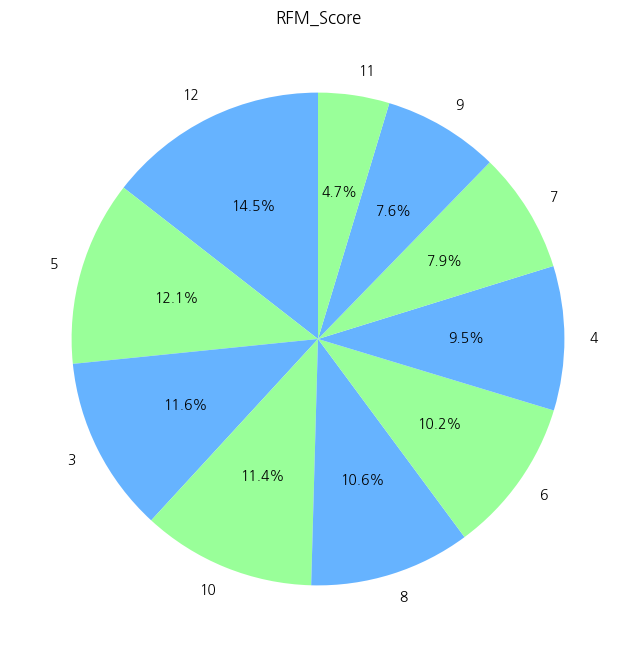

In [ ]:
plt.figure(figsize=(8, 8))
df['RFM_Score'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title('RFM_Score')
plt.ylabel('')

In [ ]:
df['VIP'] = df['RFM_Score'] >= 11

In [ ]:
X = df[['최근방문일그룹화', '구매금액그룹', '방문횟수 그룹']]
y = df['VIP']

# 상수항 추가
X = sm.add_constant(X)

# 회귀분석 모델 적합
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())

# 회귀계수 확인
coefficients = model.params

a = coefficients['최근방문일그룹화']
b = coefficients['구매금액그룹']
c = coefficients['방문횟수 그룹']

print(f"a: {a}, b: {b}, c: {c}")
#a,b,c 계수들을 총합이 1인 숫자로 변환하면 0.2 0.35 0.45

                            OLS Regression Results                            
Dep. Variable:                    VIP   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     4010.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:17:57   Log-Likelihood:                -1493.4
No. Observations:               11552   AIC:                             2995.
Df Residuals:                   11548   BIC:                             3024.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5069      0.007    -72.835      0.0

In [ ]:
# VIP 점수 계산
df['VIP점수'] = (0.2 * df['최근방문일그룹화'] + 0.35 * df['구매금액그룹'] + 0.45 * df['방문횟수 그룹'])

# VIP 선정
df['VIP선정'] = df['VIP점수'] >= 4

# 결과 출력
print(df)

             회원번호 조합원상태 성별 배송서비스신청여부 모바일알람여부    구     동     연령대  최근방문일그룹화  \
0      1000012800  정상회원  여       미신청       .  수지구  풍덕천동     50대         1   
1      1000103744  정상회원  여       미신청       .  처인구   고림동     30대         3   
2      1000122304  정상회원  여       미신청       .   광주    기타     30대         4   
3      1000163136  정상회원  여       미신청       .  수지구   동천동  70대 이상         4   
4      1000281920  정상회원  여        신청       .  수지구  풍덕천동     40대         3   
...           ...   ... ..       ...     ...  ...   ...     ...       ...   
11547   999682432  탈퇴회원  여       미신청       .  수지구   동천동     40대         1   
11548   999721408  정상회원  여       미신청       .  수지구   동천동     40대         2   
11549   999738112  정상회원  여       미신청       .  수지구   성복동     60대         4   
11550   999754816  정상회원  여        신청       .  수지구   상현동     40대         4   
11551    99995712  정상회원  여       미신청       .  수지구   상현동     60대         4   

         총구매금액  구매금액그룹  총방문횟수  방문횟수 그룹  RFM_Score    VIP  VIP점수  VIP선정  
0 

Text(0, 0.5, '')

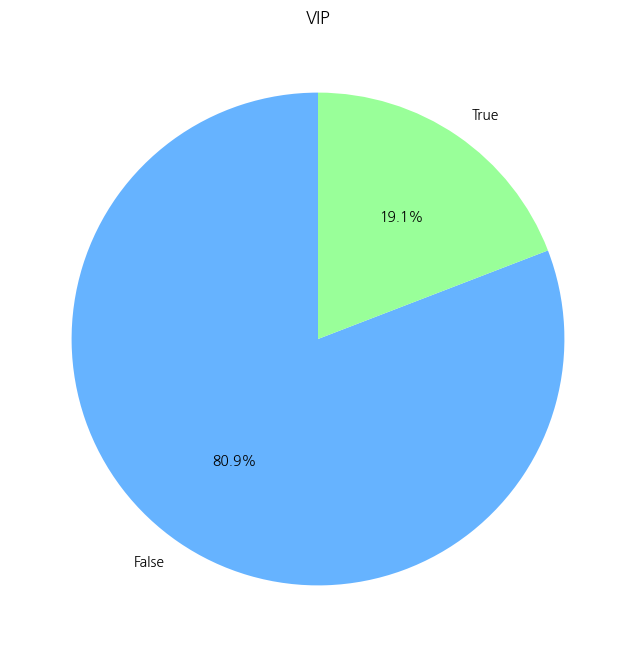

In [ ]:
plt.figure(figsize=(8, 8))
df['VIP'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title('VIP')
plt.ylabel('')

Text(0, 0.5, '')

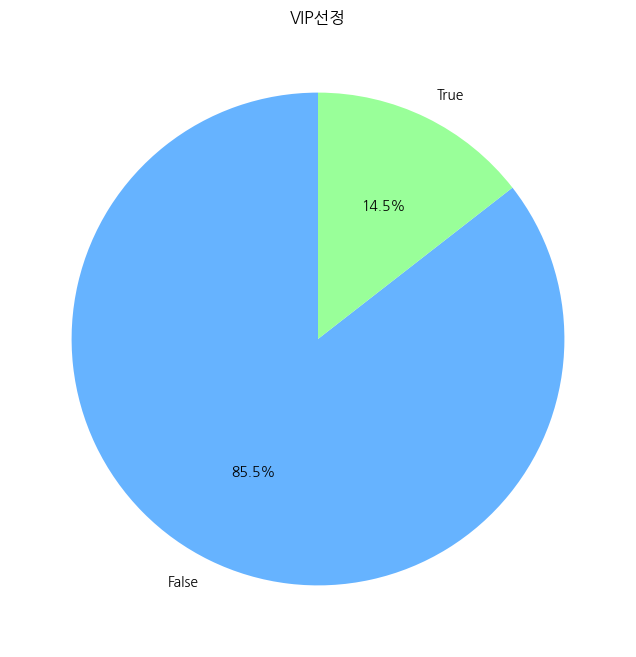

In [ ]:
plt.figure(figsize=(8, 8))
df['VIP선정'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=90)
plt.title('VIP선정')
plt.ylabel('')

In [ ]:
dfm = dfm.fillna('unknown')

In [ ]:
## 주요 내용 - 목표변수, 설명변수, 어떻게 분석

### (1) 요일별 매출 체크

In [ ]:
# 날짜 컬럼을 datetime 형식으로 변환
dfm['날짜'] = pd.to_datetime(dfm['공급일자'])

# 요일 열 추가 (0=Monday, 1=Tuesday, ..., 6=Sunday)
dfm['요일'] = dfm['날짜'].dt.dayofweek

# 요일을 문자로 변환
weekday_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
dfm['요일'] = dfm['요일'].map(weekday_map)

# 결과 확인
print(dfm.head())

         공급일자       회원번호 조합원상태 물품대분류  물품중분류   물품소분류               물품명  구매수량  \
0  2023-01-06  220954944  정상회원    반찬  두부/유부      두부       두부(1모:420g)   1.0   
1  2023-01-06   89023040  정상회원    채소   열매채소  단호박/손질    단호박(깍뚝썰기/300g)   1.0   
2  2023-01-06  354941440  정상회원   축산물      알     유정란  유정란/매장용(10알/국내산)   1.0   
3  2023-01-06  786634048  탈퇴회원    반찬   어묵/묵       묵     도토리묵(420g:1모)   1.0   
4  2023-01-06  438543104  정상회원   축산물      알     유정란  유정란/매장용(10알/국내산)   1.0   

   구매금액 구매매장  ...     반품일자     년   월   일      최근방문일   일차  최근방문일그룹화    총구매금액  \
0  3829  매장A  ...  unknown  2023  01  06 2023-01-06  302         4  3140880   
1  4977  매장A  ...  unknown  2023  01  06 2023-01-06  302         4   662576   
2  7083  매장A  ...  unknown  2023  01  06 2023-01-06  302         2   117639   
3  7083  매장A  ...  unknown  2023  01  06 2023-01-06  302         1    60304   
4  7083  매장A  ...  unknown  2023  01  06 2023-01-06  302         2   108930   

          날짜 요일  
0 2023-01-06  금  
1 2023-01-06  

          요일          평균매출
0     Friday  10935.755944
1     Monday  11080.748263
2   Saturday  11169.235585
3     Sunday  10928.162398
4   Thursday  10953.996449
5    Tuesday  11233.628185
6  Wednesday  10991.825240


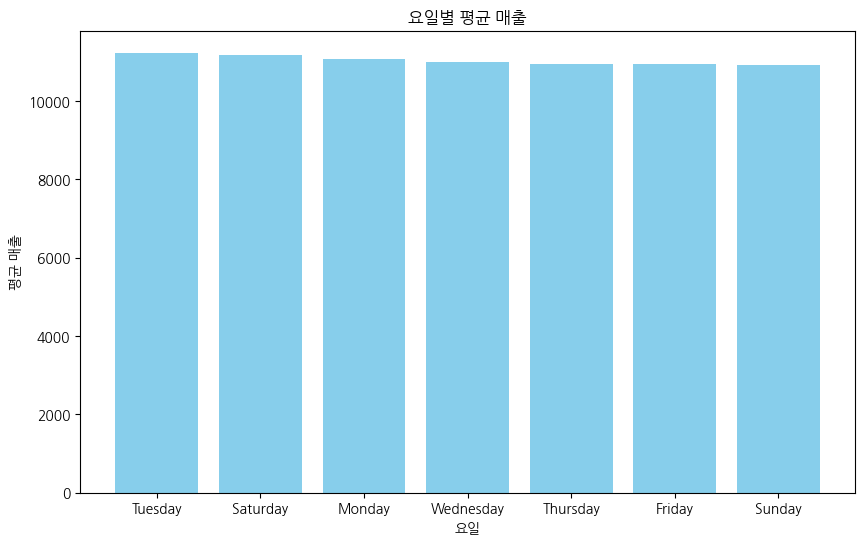

In [ ]:
# 요일별 매출 합계와 건수 집계
sales_by_weekday = dfm.groupby('요일')['구매금액'].agg(['sum', 'count']).reset_index()

# 요일별 평균 매출 계산
sales_by_weekday['평균매출'] = sales_by_weekday['sum'] / sales_by_weekday['count']

# 결과 확인
print(sales_by_weekday[['요일', '평균매출']])

# 요일별 평균 매출을 시각화
sales_by_weekday.sort_values(by='평균매출', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(sales_by_weekday['요일'], sales_by_weekday['평균매출'], color='skyblue')
plt.title('요일별 평균 매출')
plt.ylabel('평균 매출')
plt.xlabel('요일')
plt.xticks(rotation=0)

# y축에 매출액을 확실히 보이도록 수정
plt.ticklabel_format(axis='y', style='plain')
plt.show()

### (2) 시간대별 매출 체크
[ 시간대 구간 설정 ]
- 오전 시간: 10:00 ~ 12:00
- 점심 시간: 12:00 ~ 14:00
- 오후 시간: 14:00 ~ 17:00
- 퇴근 시간: 17:00 ~ 19:00
- 그 외 시간: 기타

In [ ]:
# '구매시각'을 datetime 형식으로 변환
dfm['구매시각'] = pd.to_datetime(dfm['구매시각'], format='%H:%M', errors='coerce')

# '구매시각'에서 시간을 추출
dfm['시간'] = dfm['구매시각'].dt.hour

# 시간을 기준으로 시간대 분류 함수 정의
def categorize_time(hour):
    if pd.isna(hour):
        return '기타'
    if 8 <= hour < 11:
        return '8시-11시'
    elif 11 <= hour < 14:
        return '11시-14시'
    elif 14 <= hour < 17:
        return '14시-17시'
    elif 17 <= hour <= 20:
        return '17시-20시'
    else:
        return '기타'

# 분류 함수를 사용하여 '시간대' 열 생성
dfm['시간대'] = dfm['시간'].apply(categorize_time)

# '시간대'별로 '구매금액' 합계를 계산
time_sales = dfm.groupby('시간대')['구매금액'].sum().reset_index()

# 결과 출력
print(time_sales)

       시간대        구매금액
0  11시-14시  1020568652
1  14시-17시  1010770570
2  17시-20시   772306196
3   8시-11시   448517322


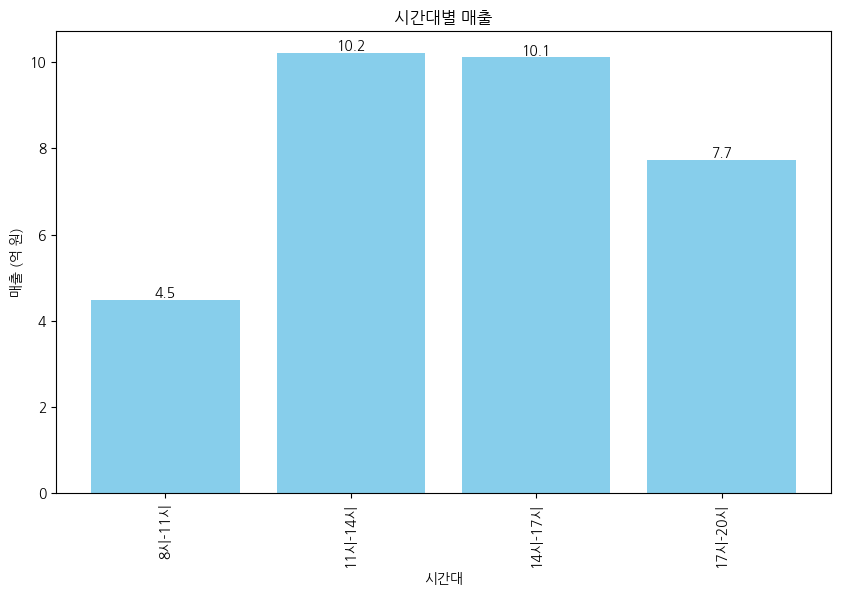

In [ ]:
# '구매금액' 단위를 억 단위로 변환
time_sales['구매금액(억 원)'] = time_sales['구매금액'] / 1e8

# 시간대별 매출 집계 및 시각화
time_sales.sort_values(by='구매금액', ascending=False, inplace=True)


# 시간대 정렬 순서 설정
time_order = ['8시-11시', '11시-14시', '14시-17시', '17시-20시', '기타']
time_sales['시간대'] = pd.Categorical(time_sales['시간대'], categories=time_order, ordered=True)
time_sales.sort_values(by='시간대', inplace=True)

# 시간대별 매출 집계 및 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(time_sales['시간대'], time_sales['구매금액(억 원)'], color='skyblue')
plt.title('시간대별 매출')
plt.ylabel('매출 (억 원)')
plt.xlabel('시간대')
plt.xticks(rotation=90)

# 그래프 안에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.show()


### (3) 날짜별 매출 추이 분석

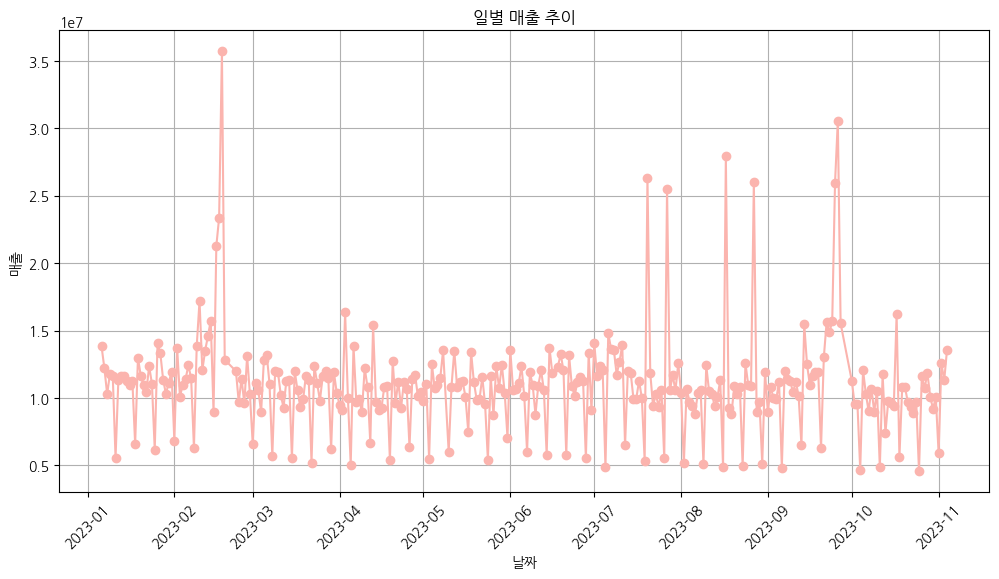

In [ ]:
# 날짜 형식으로 변환
dfm['공급일자'] = pd.to_datetime(dfm['공급일자'])

# 일별 매출 합계 계산
daily_sales = dfm.groupby(dfm['공급일자'].dt.date)['구매금액'].sum().reset_index()

# 일별 매출 추이 시각화
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['공급일자'], daily_sales['구매금액'], marker='o')
plt.title('일별 매출 추이')
plt.xlabel('날짜')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### 매출 급증 구간 확인

매출 급증 구간:
           공급일자      구매금액     매출증가율
6    2023-01-12  11304646  1.031343
13   2023-01-19  12995277  0.972407
20   2023-01-26  14041238  1.272981
27   2023-02-02  13716787  1.003133
34   2023-02-09  13866388  1.195128
41   2023-02-16  21272633  1.373553
43   2023-02-18  35683770  0.526527
52   2023-03-02  11099048  0.684708
59   2023-03-09  12032134  1.119449
66   2023-03-16  12013543  1.167542
73   2023-03-23  12400836  1.378308
80   2023-03-30  11915966  0.921518
84   2023-04-03  16376033  0.793605
87   2023-04-06  13853137  1.734444
94   2023-04-13  15421011  1.319225
101  2023-04-20  12739353  1.362377
108  2023-04-27  11436853  0.796767
115  2023-05-04  12503823  1.273064
121  2023-05-11  10850082  0.809167
128  2023-05-18  13418828  0.793111
135  2023-05-25  11625940  1.144425
142  2023-06-01  13571949  0.919201
149  2023-06-08  11899762  0.977723
156  2023-06-15  13739421  1.367515
162  2023-06-22  13159506  1.274486
169  2023-06-29  13334247  1.407514
171  2023-07-01  1

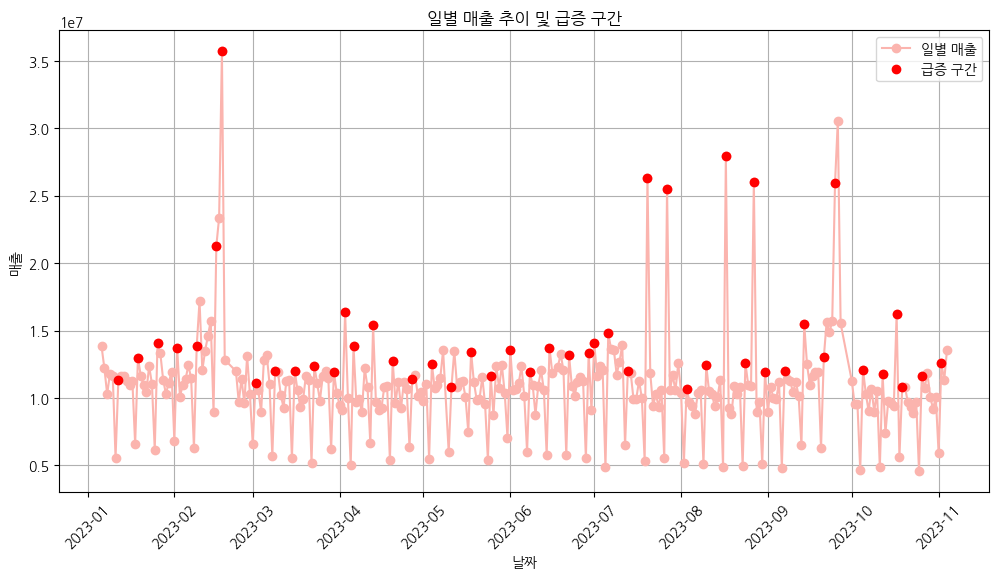

In [ ]:
# 매출 증가율 계산
daily_sales['매출증가율'] = daily_sales['구매금액'].pct_change().fillna(0)

# 매출 증가율이 급증하는 구간 확인 (증가율이 50% 이상인 구간을 급증 구간으로 설정)
threshold = 0.5
spike_periods = daily_sales[daily_sales['매출증가율'] > threshold]

# Display the spike periods
print("매출 급증 구간:")
print(spike_periods)

# Plotting the daily sales with spike periods highlighted
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['공급일자'], daily_sales['구매금액'], marker='o', label='일별 매출')
plt.scatter(spike_periods['공급일자'], spike_periods['구매금액'], color='red', label='급증 구간', zorder=5)
plt.title('일별 매출 추이 및 급증 구간')
plt.xlabel('날짜')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# # 매출 급증일
# 41   2023-02-16  21272633  1.373553
# 43   2023-02-18  35683770  0.526527
# 190  2023-07-20  26325973  3.911155
# 197  2023-07-27  25528046  3.623554
# 218  2023-08-17  27911465  4.713014
# 228  2023-08-27  26030814  1.386471
# 257  2023-09-25  25955432  0.652887

### (4) 시간대별/요일별 상품 카테고리별 매출 분석

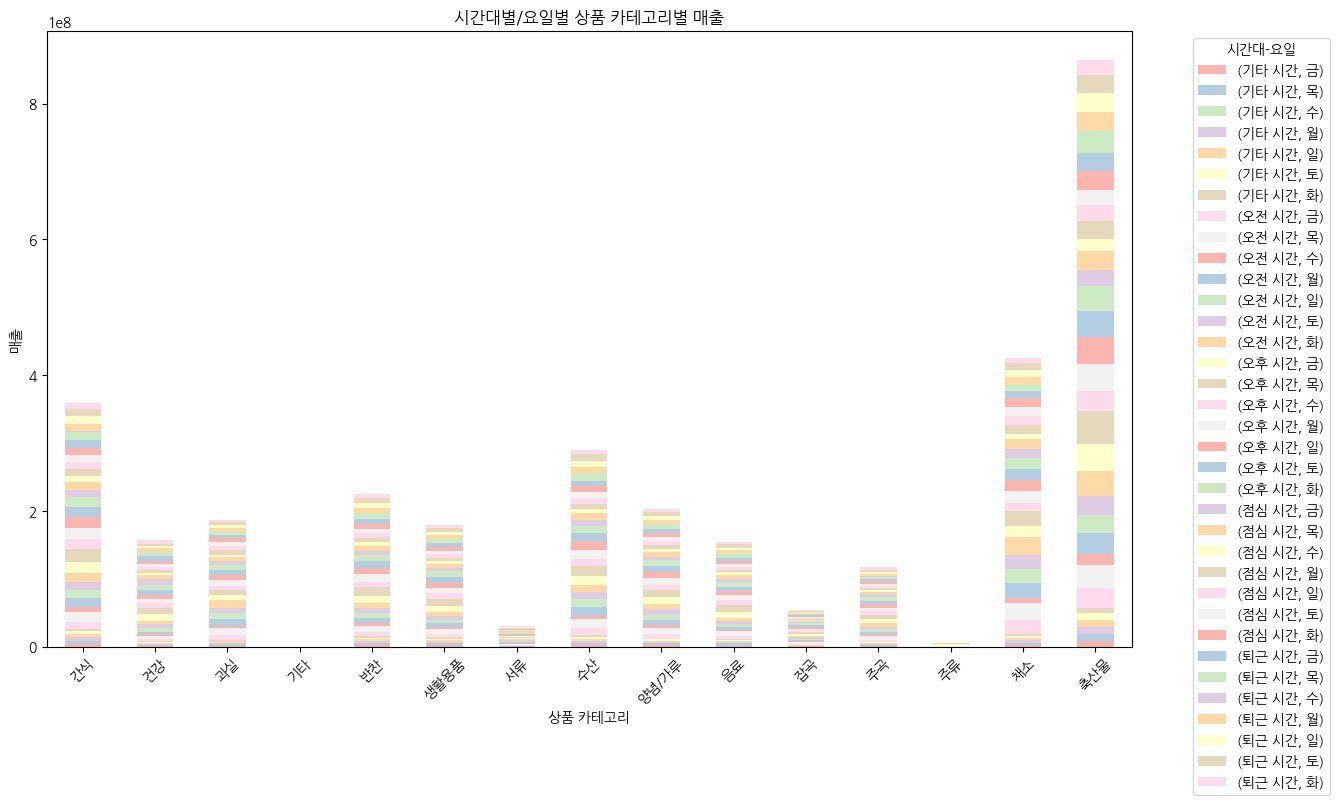

In [ ]:

# 시간대별/요일별 상품 카테고리별 매출 합계 계산
category_time_sales = dfm.groupby(['시간대', '요일', '물품대분류'])['구매금액'].sum().reset_index()

# 시각화
category_time_sales_pivot = category_time_sales.pivot(index='물품대분류', columns=['시간대', '요일'], values='구매금액').fillna(0)
category_time_sales_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('시간대별/요일별 상품 카테고리별 매출')
plt.ylabel('매출')
plt.xlabel('상품 카테고리')
plt.xticks(rotation=45)
plt.legend(title='시간대-요일', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### (5) 반품 시간대 분석

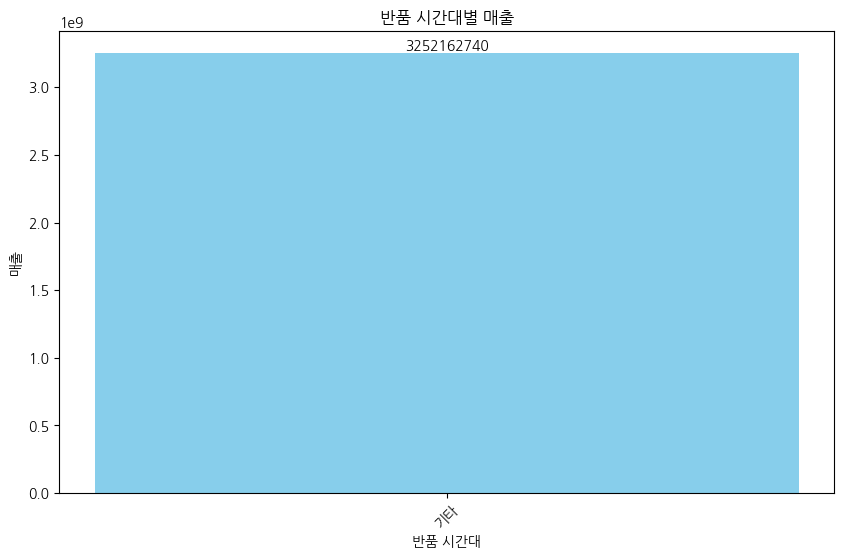

In [ ]:
# 반품 데이터 필터링 및 시간대 추가
returns = dfm.dropna(subset=['반품일자'])
returns['반품시각'] = pd.to_datetime(returns['반품일자'].str.split().str[1], format='%H:%M', errors='coerce')
returns['반품시간'] = returns['반품시각'].dt.hour
returns['반품시간대'] = returns['반품시간'].apply(categorize_time)

# 반품 시간대별 매출 합계 계산
return_time_sales = returns.groupby('반품시간대')['구매금액'].sum().reset_index()

# "기타 시간"을 강조하여 시각화
colors = ['lightcoral' if x == '기타 시간' else 'skyblue' for x in return_time_sales['반품시간대']]

plt.figure(figsize=(10, 6))
plt.bar(return_time_sales['반품시간대'], return_time_sales['구매금액'], color=colors)
plt.title('반품 시간대별 매출')
plt.xlabel('반품 시간대')
plt.ylabel('매출')
plt.xticks(rotation=45)

# 그래프 안에 값 표시
for i in range(len(return_time_sales)):
    plt.text(i, return_time_sales['구매금액'][i], f'{return_time_sales["구매금액"][i]:.0f}', ha='center', va='bottom')

plt.show()

### (6) 주중과 주말 매출 비교

주중과 주말 매출 비교:
  주중주말        구매금액
0   주말   955528447
1   주중  2296634293


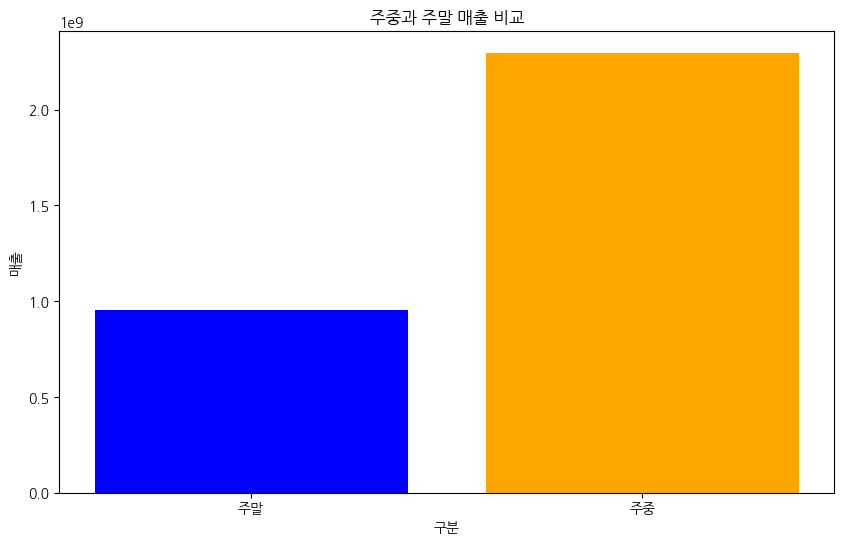

In [ ]:
# '공급일자'를 datetime 형식으로 변환하고 '요일' 컬럼 추가
dfm['공급일자'] = pd.to_datetime(dfm['공급일자'])
dfm['요일'] = dfm['공급일자'].dt.day_name()

# 주중과 주말을 정의
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

dfm['주중주말'] = dfm['요일'].apply(lambda x: '주중' if x in weekdays else '주말')

# '주중주말' 열 생성
weekday_weekend_sales = dfm.groupby('주중주말')['구매금액'].sum().reset_index()

# Display the results
print("주중과 주말 매출 비교:")
print(weekday_weekend_sales)

# Plotting the sales data
plt.figure(figsize=(10, 6))
plt.bar(weekday_weekend_sales['주중주말'], weekday_weekend_sales['구매금액'], color=['blue', 'orange'])
plt.title('주중과 주말 매출 비교')
plt.ylabel('매출')
plt.xlabel('구분')
plt.xticks(rotation=0)
plt.show()


### (7) 시간대별/요일별 고객 재방문율

시간대별/요일별 고객 재방문율:
      시간대         요일       재방문
0   기타 시간     Friday  0.978955
1   기타 시간     Monday  0.991821
2   기타 시간   Saturday  0.984637
3   기타 시간     Sunday  0.989116
4   기타 시간   Thursday  0.985014
5   기타 시간    Tuesday  0.982119
6   기타 시간  Wednesday  1.000000
7   오전 시간     Friday  0.988914
8   오전 시간     Monday  0.987989
9   오전 시간   Saturday  0.990166
10  오전 시간     Sunday  0.989648
11  오전 시간   Thursday  0.990042
12  오전 시간    Tuesday  0.986630
13  오전 시간  Wednesday  0.989115
14  오후 시간     Friday  0.982385
15  오후 시간     Monday  0.984980
16  오후 시간   Saturday  0.982057
17  오후 시간     Sunday  0.983393
18  오후 시간   Thursday  0.983597
19  오후 시간    Tuesday  0.976067
20  오후 시간  Wednesday  0.981020
21  점심 시간     Friday  0.984683
22  점심 시간     Monday  0.983104
23  점심 시간   Saturday  0.982104
24  점심 시간     Sunday  0.978997
25  점심 시간   Thursday  0.985366
26  점심 시간    Tuesday  0.979740
27  점심 시간  Wednesday  0.984064
28  퇴근 시간     Friday  0.982881
29  퇴근 시간     Monday  0.987263
30  퇴근 시간   Saturday 

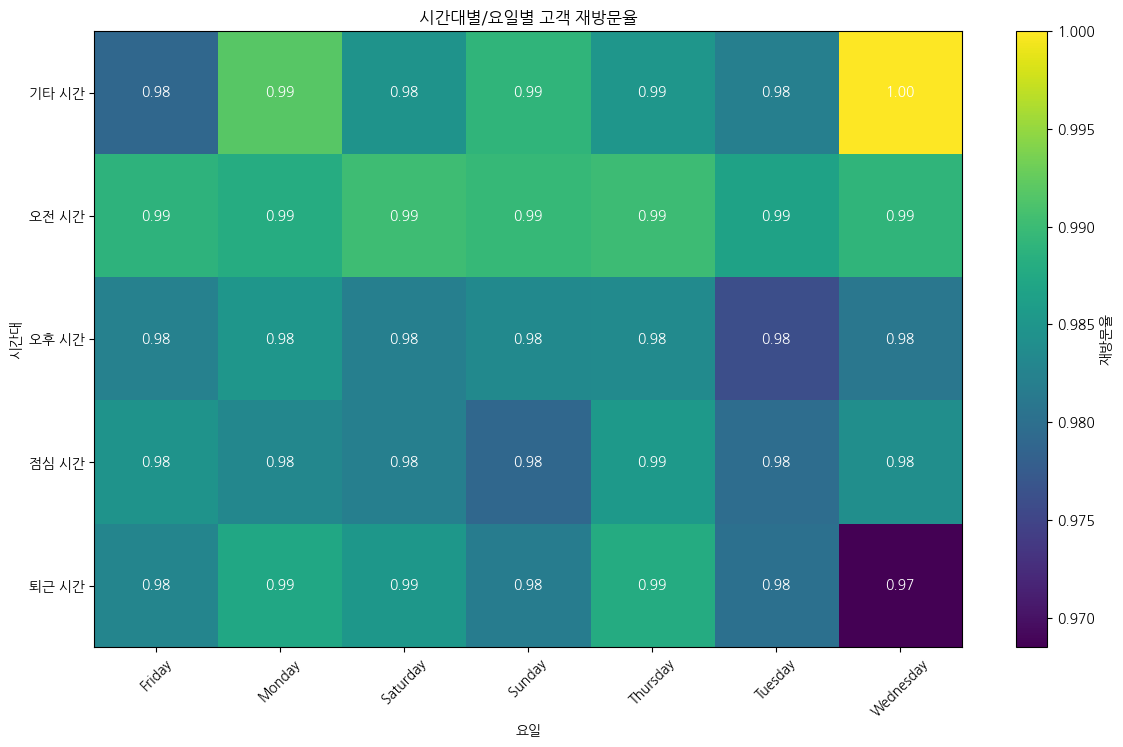

In [ ]:
# 각 고객의 방문 횟수를 계산하여 '방문횟수' 열에 저장
dfm['방문횟수'] = dfm.groupby('회원번호')['공급일자'].transform('nunique')

# 방문 횟수가 1회 이상이면 재방문으로 간주하여 '재방문' 열에 저장
dfm['재방문'] = dfm['방문횟수'] > 1

# 시간대와 요일별로 재방문율 계산
revisit_rate = dfm.groupby(['시간대', '요일'])['재방문'].mean().reset_index()

# 결과 출력
print("시간대별/요일별 고객 재방문율:")
print(revisit_rate)

# 데이터 시각화를 위해 피벗 테이블 생성
revisit_rate_pivot = revisit_rate.pivot(index='시간대', columns='요일', values='재방문')

# 재방문율 데이터 시각화
plt.figure(figsize=(14, 8))
plt.imshow(revisit_rate_pivot, cmap='viridis', aspect='auto')
plt.colorbar(label='재방문율')
plt.title('시간대별/요일별 고객 재방문율')
plt.xlabel('요일')
plt.ylabel('시간대')
plt.xticks(range(len(revisit_rate_pivot.columns)), revisit_rate_pivot.columns, rotation=45)
plt.yticks(range(len(revisit_rate_pivot.index)), revisit_rate_pivot.index)

# 각 셀에 값 표시
for i in range(len(revisit_rate_pivot.index)):
    for j in range(len(revisit_rate_pivot.columns)):
        value = revisit_rate_pivot.iloc[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='white')

plt.show()


### (8) 계절별 매출 분석

계절별 매출:
   계절        구매금액
0  가을   682715145
1  겨울   626265436
2   봄   937472313
3  여름  1005709846


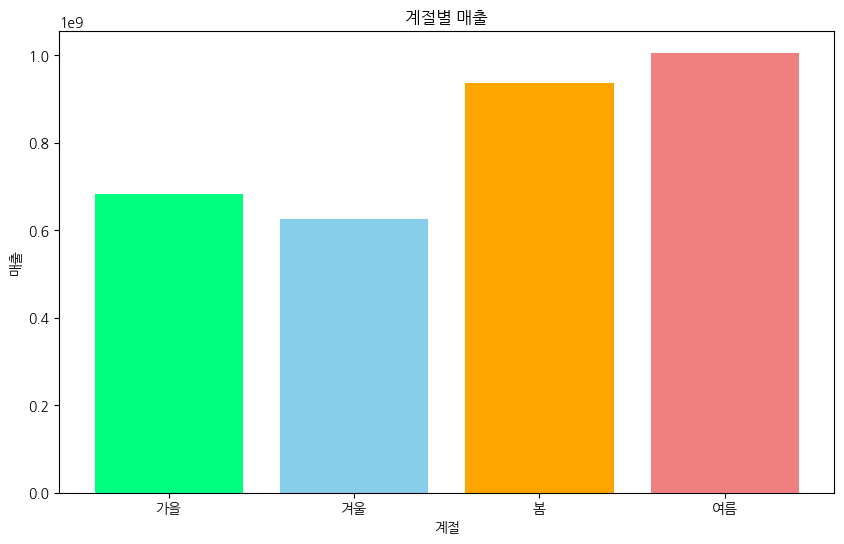

In [ ]:
# '공급일자'를 datetime 형식으로 변환
dfm['공급일자'] = pd.to_datetime(dfm['공급일자'])

# 계절을 분류하는 함수 정의
def categorize_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

# '계절' 열 생성
dfm['월'] = dfm['공급일자'].dt.month
dfm['계절'] = dfm['월'].apply(categorize_season)

# 계절별 매출 합계 계산
season_sales = dfm.groupby('계절')['구매금액'].sum().reset_index()

# 결과 출력
print("계절별 매출:")
print(season_sales)

# 계절별 매출을 시각화
plt.figure(figsize=(10, 6))
plt.bar(season_sales['계절'], season_sales['구매금액'], color=['springgreen', 'skyblue', 'orange', 'lightcoral'])
plt.title('계절별 매출')
plt.ylabel('매출')
plt.xlabel('계절')
plt.xticks(rotation=0)
plt.show()


### (9) 시간대별 상품 카테고리별 매출

In [ ]:
# 시간대별 상품 카테고리별 매출 합계 계산
category_time_sales = dfm.groupby(['시간대', '물품대분류'])['구매금액'].sum().unstack().fillna(0)

# 시간대별 상품 카테고리별 매출을 시각화
category_time_sales.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('시간대별 상품 카테고리별 매출')
plt.ylabel('매출')
plt.xlabel('시간대')
plt.xticks(rotation=45)
plt.legend(title='상품 카테고리', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


NameError: name 'dfm' is not defined